In [1]:
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import xarray as xr
import glob
import os

import py7zr
import zipfile

### Import shared files

In [2]:
covariate_metadata = pd.read_csv('../DATA/Stream_Temp/covariate_metadata.csv', nrows = 100)
covariate_metadata.tail(5)

COVARIATE     UNITS    SYMBOL  \
95          lookup  unitless  not used   
96        tim.date      date  not used   
97        tim.year      year  not used   
98  cov.canopy_rca   percent  not used   
99   cov.canopy_ws   percent  not used   

                                          DESCRIPTION  \
95  concatination of reach identifier, year, and d...   
96                                               date   
97                                               year   
98  proportional canopy cover in the reach contrib...   
99  proportional canopy cover in the upstream wate...   

   DATA SOURCE (Retrospective) DATA SOURCE (GCM Scenarios)  
95                         NaN                         NaN  
96                         NaN                         NaN  
97                         NaN                         NaN  
98               need to check                         NaN  
99               need to check                         NaN

In [3]:
gcm_metadata = pd.read_csv('../DATA/Stream_Temp/gcm_metadata.csv', nrows = 10)
gcm_metadata

Global Climate Model short name  \
0                         CanESM2   
1                           CCSM4   
2                        CNRM-CM5   
3                   CSIRO-Mk3-6-0   
4                      GDFL-ESM2M   
5                    HadGEM-CC365   
6                      HadGEM2-ES   
7                          inmcm4   
8                    IPSL-CM5A-MR   
9                          MIROC5   

                                       GCM long name    Country  \
0              Canadian Earth System Model version 2     Canada   
1           Community Climate System Model version 4        USA   
2  National Center for Meteorological Research Mo...     France   
3  Commonwealth Scientific and Industrial Researc...  Australia   
4  Global Fluid Dynamics Lab's Earth Systems Mode...        USA   
5  Hadley Centre Global Environmental Model, Clim...         UK   
6  Hadley Centre Global Environmental Model, Eart...         UK   
7  Institute of Numerical Mathematics, Coupled Mo...     Russia   
8        Institut Pierre Simon Laplace Climate Model     France   
9  Model for Interdisciplinary Research on Climat...      Japan   

                                              Agency  \
0  Canadian Centre for Climate Modeling and Analysis   
1       National Center of Atmospheric Research, USA   
2  National Centre of Meteorological Research, Fr...   
3  Commonwealth Scientific and Industrial Researc...   
4    NOAA Geophysical Fluid Dynamics Laboratory, USA   
5                       Met Office Hadley Center, UK   
6                       Met Office Hadley Center, UK   
7         Institute of Numerical Mathematics, Russia   
8              Institut Pierre Simon Laplace, France   
9  Atmosphere and Ocean Research Institute (The U...   

   Coupled Model Intercomparison Project version Emissions scenario  \
0                                              5            RCP 8.5   
1                                              5            RCP 8.5   
2                                              5            RCP 8.5   
3                                              5            RCP 8.5   
4                                              5            RCP 8.5   
5                                              5            RCP 8.5   
6                                              5            RCP 8.5   
7                                              5            RCP 8.5   
8                                              5            RCP 8.5   
9                                              5            RCP 8.5   

                                  Downscaling method  \
0  Multivariate Adaptive Constructed Analogs (Aba...   
1  Multivariate Adaptive Constructed Analogs (Aba...   
2  Multivariate Adaptive Constructed Analogs (Aba...   
3  Multivariate Adaptive Constructed Analogs (Aba...   
4  Multivariate Adaptive Constructed Analogs (Aba...   
5  Multivariate Adaptive Constructed Analogs (Aba...   
6  Multivariate Adaptive Constructed Analogs (Aba...   
7  Multivariate Adaptive Constructed Analogs (Aba...   
8  Multivariate Adaptive Constructed Analogs (Aba...   
9  Multivariate Adaptive Constructed Analogs (Aba...   

                                     Hydrology model  \
0  Variable Infiltration Capacity, using paramete...   
1  Variable Infiltration Capacity, using paramete...   
2  Variable Infiltration Capacity, using paramete...   
3  Variable Infiltration Capacity, using paramete...   
4  Variable Infiltration Capacity, using paramete...   
5  Variable Infiltration Capacity, using paramete...   
6  Variable Infiltration Capacity, using paramete...   
7  Variable Infiltration Capacity, using paramete...   
8  Variable Infiltration Capacity, using paramete...   
9  Variable Infiltration Capacity, using paramete...   

             Network routing  
0  mizuRoute (Mizukami 2019)  
1  mizuRoute (Mizukami 2019)  
2  mizuRoute (Mizukami 2019)  
3  mizuRoute (Mizukami 2019)  
4  mizuRoute (Mizukami 2019)  
5  mizuRoute (Mizukami 2019)  
6  miz

In [4]:
gcms = list(gcm_metadata.iloc[:, 0].values)

shortname_dict = {i+1:gcms[i] for i in list(range(10))}
shortname_dict

{1: 'CanESM2',
 2: 'CCSM4',
 3: 'CNRM-CM5',
 4: 'CSIRO-Mk3-6-0',
 5: 'GDFL-ESM2M',
 6: 'HadGEM-CC365',
 7: 'HadGEM2-ES',
 8: 'inmcm4',
 9: 'IPSL-CM5A-MR',
 10: 'MIROC5'}

In [225]:
def gapCheck(indf): 
    """Check for gaps in dataframe with COMID and date columns"""
    gap_end_date = []
    gap_length = []
    no_comids = []
   
    indf_sorted = indf.sort_values(by = ['COMID', 'date'])
    indf_sorted['timedelta'] = indf_sorted['date'].diff()
    indf_gaps = indf_sorted[indf_sorted.timedelta > '1 day']
    if len(indf_gaps) > 0:
        print(f'Gaps in {cur_huc}')
        for d in indf_gaps.date.unique():
            for l in indf_gaps.loc[(indf_gaps.date == d)].timedelta.unique():
                cur_gap = indf_gaps.loc[(indf_gaps.date == d) & (indf_gaps.timedelta == l)]
                gap_hucs.append(cur_huc)
                gap_end_date.append(d.date())
                gap_length.append(l)
                no_comids.append(round(len(cur_gap.COMID.unique())/len(indf.COMID.unique()), 2))
        return pd.DataFrame({'end_date': gap_end_date, 'length': gap_length, 'fraction_COMIDS': no_comids})
    else: return pd.DataFrame()

In [5]:
# the following use ~ mm/21/yy dates for cutting (i.e. spring starts on March 21) - per Aimee

def assign_season(doy):
    """Assigns a season based on the day of year (doy)."""
    if 1 <= doy <= 79:
        return "winter"
    elif 80 <= doy <= 171:
        return "spring"
    elif 172 <= doy <= 263:
        return "summer"
    elif 264 <= doy <= 356:
        return "fall"
    else:
        return "winter"

In [6]:
def assign_water_year(date):
    """Assigns water year (Oct-Sept) based on date."""
    if date.month >= 10:
        return (date.year +1)
    else: return date.year

In [216]:
# (~4 sec/HUC)
def getSeasonalAnomalies(indf, baseline_period: range, anomaly_periods: list, cols: list):
    cur_huc_anoms = []
    cur_comids = list(indf.COMID.unique())
    for j in cur_comids:
        #Assign water year and season
        cur_df = indf[indf.COMID == j][['date']+ cols]
        cur_ens_med = cur_df.groupby('date').median() # sets index to date
        cur_ens_med['doy'] = cur_ens_med.index.dayofyear
        cur_ens_med['season'] = cur_ens_med['doy'].apply(assign_season)
        for col in cols: cur_ens_med[f'n_{col}'] = cur_ens_med[col].notnull().astype(int)

        if 'cov.SWE' in cols:
            #Use water year for swe
            cur_swe = cur_ens_med.copy()
            cur_swe['WY'] = cur_swe.index.to_series().apply(assign_water_year)
    
            # Reclassify end of Sept as summer (pull it into summer of WY[y-1])
            cur_swe.loc[cur_swe.index.month == 9, 'season'] = 'summer'        
            swe_cum = cur_swe[['cov.SWE', 'WY', 'season', 'n_cov.SWE']].groupby(['WY', 'season']).sum()

        
        cur_anomalies = {}
        
        #Determine baseline (median)
        cur_met = cur_ens_med.copy()
        baseline = cur_met[cur_met.index.year.isin(baseline_period)].groupby('season').median()
        for col in cols: 
            baseline[f'n_{col}'] = cur_met[cur_met.index.year.isin(baseline_period)].groupby('season').sum()[f'n_{col}'] # n
            
        if 'cov.SWE' in cols:
            swe_df = swe_cum.loc[pd.IndexSlice[baseline_period], :, :]                
            baseline['cov.SWE'] = swe_df.groupby(level=1).median()['cov.SWE']
            baseline['n_cov.SWE'] = swe_df.groupby(level=1).sum()['n_cov.SWE'] # n
        
        
        baseline_trim = pd.concat([baseline[[col, f'n_{col}']] for col in cols], axis = 1)
        
        cur_anomalies[f'{baseline_period[0]}s'] = baseline_trim

        #Calculate anomalies
        for per in anomaly_periods:                
            cur_anoms = cur_ens_med[cur_ens_med.index.year.isin(per)].groupby('season').median().subtract(baseline)
            for col in cols: 
                cur_anoms[f'n_{col}'] = cur_ens_med[cur_ens_med.index.year.isin(per)].groupby('season').sum()[f'n_{col}'] # n

            if 'cov.SWE' in cols:
                swe = swe_cum.loc[pd.IndexSlice[per], :, :]                
                cur_anoms['cov.SWE'] = swe.groupby(level=1).median()['cov.SWE'].subtract(baseline['cov.SWE'])
                cur_anoms['n_cov.SWE'] = swe.groupby(level=1).sum()['n_cov.SWE'] # n
            
            cur_anoms_trim = pd.concat([cur_anoms[[col, f'n_{col}']] for col in cols], axis = 1)
            
            cur_anomalies[f'{per[0]}s'] = cur_anoms_trim
        
        cur_seas_anomalies = pd.concat(cur_anomalies, axis = 1)
        cur_huc_anoms.append(cur_seas_anomalies)
    return pd.concat(cur_huc_anoms, keys = cur_comids)
 

In [8]:
temp_dir = '/Volumes/Elements/URycki/temp_data/'

In [9]:
periods = {'2000s': list(range(2000, 2010)),
           '2010s': list(range(2010, 2020)),
           '2020s': list(range(2020, 2030)), 
           '1990s': list(range(1990, 2000)), 
           '2050s': list(range(2050, 2060)), 
           '2080s': list(range(2080, 2090))}

In [13]:
temp_dir_gcms = os.path.join(temp_dir, 'preds_GCM/')
temp_files_gcms = glob.glob(temp_dir_gcms + '*.nc')
print(len(temp_files_gcms))
temp_files_gcms.sort()

1316


In [14]:
temp_dir_retro = os.path.join(temp_dir, 'preds_retro/')
temp_files_retro = glob.glob(temp_dir_retro + '*.7z')
print(len(temp_files_retro))
print(temp_files_retro[:3])
temp_files_retro.sort()

22
['/Volumes/Elements/URycki/temp_data/preds_retro/st_pred_171100.7z', '/Volumes/Elements/URycki/temp_data/preds_retro/st_pred_170501.7z', '/Volumes/Elements/URycki/temp_data/preds_retro/st_pred_170402.7z']


In [ ]:
huc6s = [f[-9:-3] for f in temp_files_retro]

In [16]:
hucs = [f[-13:-3] for f in temp_files_gcms]
#hucs

## Temperature anomalies

In [20]:
%%time

# Temp anomalies

for cur_huc in hucs[:2]:
    print(cur_huc)

    preds = xr.open_dataset(f'/Volumes/Elements/URycki/temp_data/preds_GCM/{cur_huc}.nc', decode_times=True)
    predsdf = preds.to_dataframe(dim_order = ['COMID', 'GCM', 'date'])
    preds_flat = predsdf.reset_index()

    huc_anoms = getSeasonalAnomalies(preds_flat, baseline_period = periods['2010s'], 
                            anomaly_periods = [periods[key] for key in ('1990s', '2050s', '2080s')], cols = ['prd.stream_temp'])
    
    huc_anoms.reset_index(names = ['COMID', 'season']).to_csv(
        os.path.join(temp_dir_gcms, 'seasonal_anomolies', f'{cur_huc}_anoms.csv'), index = False) #, compression = 'zip')

1701010107
1701010108
CPU times: user 5.83 s, sys: 765 ms, total: 6.6 s
Wall time: 22.5 s


In [21]:
pd.read_csv(os.path.join(temp_dir_gcms, 'seasonal_anomolies', f'{cur_huc}_anoms.csv'), header=[0,1])

COMID             season           2010s                    \
    Unnamed: 0_level_1 Unnamed: 1_level_1 prd.stream_temp n_prd.stream_temp   
0             22878623               fall        3.921150               930   
1             22878623             spring        8.469155               920   
2             22878623             summer       15.968426               920   
3             22878623             winter        0.794843               882   
4             22878625               fall        3.965583               930   
..                 ...                ...             ...               ...   
123           22879895             winter        0.323003               882   
124           22879989               fall        2.040540               930   
125           22879989             spring        3.544079               920   
126           22879989             summer        8.605773               920   
127           22879989             winter        0.726483               882   

              1990s                             2050s                    \
    prd.stream_temp n_prd.stream_temp prd.stream_temp n_prd.stream_temp   
0         -0.299178               930        1.096812               930   
1         -0.411885               920        1.633280               920   
2         -0.946710               920        1.242376               920   
3         -0.155174               882        0.526287               882   
4         -0.296498               930        1.080081               930   
..              ...               ...             ...               ...   
123        0.103842               882        0.419040               882   
124       -0.095128               930        0.127186               930   
125       -0.016492               920        0.421183               920   
126       -0.496326               920        0.659330               920   
127       -0.097199               882        0.197353               882   

              2080s                    
    prd.stream_temp n_prd.stream_temp  
0          2.240112               930  
1          2.942516               920  
2          2.557516               920  
3          1.571385               883  
4          2.268231               930  
..              ...               ...  
123        1.216069               883  
124        0.459159               930  
125        0.953634               920  
126        1.039228               920  
127        0.324427               883  

[128 rows x 10 columns]

In [ ]:
%%time
# Retrospective (input by 6-digit HUC)
gap_frames = []

for h6 in huc6s:
    print(h6)

    tmp_path = os.path.join(temp_dir_retro, 'temp_files', h6)
    if not os.path.exists(tmp_path):
        os.makedirs(tmp_path)
        with py7zr.SevenZipFile(os.path.join(temp_dir_retro, f'st_pred_{h6}.7z'), mode='r') as z:
            z.extractall(path = os.path.join(tmp_path))

    huc10_files = glob.glob(os.path.join(tmp_path, '*.csv'))
    huc10_files.sort()
    print(len(huc10_files), ' huc10s')

    for h in huc10_files[14:]:
        cur_huc = h[-14:-4] 
        print('\t', f'{cur_huc}')
    
        stdf = pd.read_csv(h, parse_dates = ['tim.date'], engine = 'python', on_bad_lines = 'warn')
        stdf.rename({'tim.date': 'date'}, axis = 1, inplace = True)
        stdf.drop('lookup', axis = 1)

        gaps = gapCheck(stdf)
        if len(gaps) > 0: 
            gaps['huc10'] = cur_huc
            gap_frames.append(gaps)
gaps_df = pd.concat(gap_frames, ignore_index = True)

In [245]:
gaps_df.to_csv(os.path.join(temp_dir_retro, 'ts_gaps_retro.csv'),index = False)

In [ ]:
     
        try:
            huc_anoms_retro = getSeasonalAnomalies(stdf, baseline_period = periods['2010s'], 
                                        anomaly_periods = [periods[key] for key in ('1990s', '2000s')], cols = ['prd.stream_temp'])
            
            huc_anoms_retro.reset_index(names = ['COMID', 'season']).to_csv(
                os.path.join(temp_dir_retro, 'seasonal_anomalies', f'{cur_huc}_anoms.zip'), index = False, compression = 'zip')
    
        except: print('Fail')

170402
145  huc10s
	 1704020207
	 1704020301


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x10f627440>>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/temp-data-env/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


	 1704020302


In [275]:
h

'/Volumes/Elements/URycki/temp_data/preds_retro/seasonal_covariate_anomalies/1701010108_cov_anoms.zip'

In [287]:
# Caution: This cell takes ~3 hours to run
# Cov files
retro_cov_comids = {}
for h in cov_csvs:
    cur_huc = h[-19:-9]
    print('\t', f'{cur_huc}')

    stdf = pd.read_csv(h, usecols = ['COMID'])
    retro_cov_comids[cur_huc] = stdf.COMID.unique().tolist()

	 1701010106
	 1701010107
	 1701010108
	 1701010109
	 1701010110
	 1701010111
	 1701010112
	 1701010113
	 1701010114
	 1701010115
	 1701010116
	 1701010117
	 1701010201
	 1701010202
	 1701010203
	 1701010204
	 1701010301
	 1701010302
	 1701010303
	 1701010304
	 1701010305
	 1701010401
	 1701010402
	 1701010403
	 1701010404
	 1701010405
	 1701010406
	 1701010407
	 1701010502
	 1701010504
	 1701010505
	 1701010607
	 1701020101
	 1701020102
	 1701020103
	 1701020104
	 1701020105
	 1701020106
	 1701020107
	 1701020108
	 1701020201
	 1701020202
	 1701020203
	 1701020204
	 1701020205
	 1701020206
	 1701020207
	 1701020208
	 1701020209
	 1701020210
	 1701020211
	 1701020212
	 1701020213
	 1701020214
	 1701020301
	 1701020302
	 1701020303
	 1701020304
	 1701020305
	 1701020306
	 1701020307
	 1701020308
	 1701020309
	 1701020310
	 1701020311
	 1701020312
	 1701020313
	 1701020401
	 1701020402
	 1701020403
	 1701020404
	 1701020405
	 1701020406
	 1701020407
	 1701020408
	 1701020501
	 1701020502

In [288]:
retro_cov_comids

{'1701010106': [22878861, 22878865, 22879677, 22879685],
 '1701010107': [22878641,
  22878643,
  22878645,
  22878647,
  22878649,
  22878651,
  22878653,
  22878655,
  22878657,
  22878659,
  22878661,
  22878663,
  22878665,
  22878667,
  22878669,
  22878671,
  22878673,
  22878675,
  22878677,
  22878679,
  22878681,
  22878683,
  22878685,
  22878687,
  22878689,
  22878691,
  22878693,
  22878695,
  22878697,
  22878699,
  22878701,
  22878703,
  22878705,
  22878707,
  22878709,
  22878711,
  22878713,
  22878715,
  22878719,
  22878721,
  22878723,
  22878725,
  22878727,
  22878729,
  22878731,
  22878733,
  22878735,
  22878737,
  22878739,
  22878741,
  22878743,
  22878745,
  22878747,
  22878749,
  22878751,
  22878753,
  22878755,
  22878757,
  22878759,
  22878761,
  22878763,
  22878765,
  22878767,
  22878769,
  22878771,
  22878773,
  22878775,
  22878777,
  22878779,
  22878781,
  22878783,
  22879327,
  22879329,
  22879331,
  22879333,
  22879335,
  22879337,
  228

In [306]:
frames = []
for k in retro_cov_comids.keys():
    curdf = pd.DataFrame(retro_cov_comids[k], columns = ['COMID']).astype({'COMID': int})
    curdf['huc10'] = k
    frames.append(curdf)
comids = pd.concat(frames).set_index('COMID')
comids.to_csv(os.path.join(temp_dir_retro, 'comids_by_huc_cov_retro.csv'))

In [307]:
pd.concat(frames).dtypes


COMID     int64
huc10    object
dtype: object

In [308]:
comids

huc10
COMID               
22878861  1701010106
22878865  1701010106
22879677  1701010106
22879685  1701010106
22878641  1701010107
...              ...
24073327  1712000908
24073341  1712000908
24073365  1712000908
24075495  1712000908
24075499  1712000908

[225174 rows x 1 columns]

In [281]:
cur_huc = h[-19:-9]
cur_huc

'1701010106'

In [286]:
cov_csvs.sort()

In [284]:
retro_cov_comids['1701010115']

[22877879,
 22877881,
 22877883,
 22877885,
 22877887,
 22877889,
 22877891,
 22877893,
 22877895,
 22877897,
 22877899,
 22877901,
 22877903,
 22877905,
 22877907,
 22877909,
 22877911,
 22877913,
 22877915,
 22877917,
 22877919,
 22877921,
 22877923,
 22877925,
 22877927,
 22877929,
 22877931,
 22877933,
 22877935,
 22877937,
 22877939,
 22877941,
 22877943,
 22877945,
 22877947,
 22877949,
 22877951,
 22877953,
 22877955,
 22877957,
 22877959,
 22877961,
 22877963,
 22877965,
 22877967,
 22877969,
 22877971,
 22877973,
 22877975,
 22877977,
 22877979,
 22877981,
 22877983,
 22877985,
 22877987,
 22879149,
 22879151,
 22879153,
 22879155,
 22879157,
 22879159,
 22879161,
 22879163,
 22879165,
 22879167,
 22879169,
 22879171,
 22879173,
 22879175,
 22879177,
 22879179,
 22879181,
 22879183,
 22879185,
 22879187,
 22879189,
 22879191,
 22879193,
 22879339,
 22879341,
 22879343,
 22879345,
 22879565,
 22879623,
 22879625,
 22879627,
 22879629,
 22879631,
 22879633,
 22879635,
 22879637,

In [274]:
pd.read_csv(h)

COMID  season               2010s            2010s.1  \
0           NaN     NaN     cov.air_temp_ws  n_cov.air_temp_ws   
1    22878621.0    fall  1.5851298629926052                930   
2    22878621.0  spring   7.163765450329025                920   
3    22878621.0  summer   16.07111205037915                920   
4    22878621.0  winter   -2.72595136340552                882   
..          ...     ...                 ...                ...   
564  22880091.0  winter  -4.385000228881835                882   
565  22882601.0    fall   2.135435196926065                930   
566  22882601.0  spring   8.162848352122834                920   
567  22882601.0  summer  17.054262007853403                920   
568  22882601.0  winter  -2.138461000670605                882   

                 2010s.2             2010s.3  2010s.4    2010s.5  \
0       cov.NWM_flow_log  n_cov.NWM_flow_log  cov.SWE  n_cov.SWE   
1     1.6154199617599059                 930     89.5        828   
2     3.0368723525091132                 920      0.0        920   
3     1.9300710626738253                 920      0.0       1022   
4     1.4206957654854813                 882   1452.0        882   
..                   ...                 ...      ...        ...   
564  -11.512925464970229                 882  13112.0        882   
565   -1.832581486100054                 930     83.5        828   
566  -0.3011051151356638                 920      0.0        920   
567  -1.1394343055401057                 920      0.0       1022   
568  -1.7719568642836168                 882   1437.5        882   

                   1990s            1990s.1               1990s.2  \
0        cov.air_temp_ws  n_cov.air_temp_ws      cov.NWM_flow_log   
1    -1.0518244298415786                930  -0.11579693768475341   
2     -0.845250073736235                920  -0.22867522515370764   
3    -1.4524947362180995                920  0.030023699021701766   
4    -0.3418913685417646                882  -0.10697211955216823   
..                   ...                ...                   ...   
564  -0.5420000553131095                882                   0.0   
565   -1.213825878314982                930   0.17185025692666067   
566  -1.0489147970619843                920  -0.34329727713739516   
567  -1.6867944138150026                920   0.36290549368936775   
568  -0.5345779989345805                882  -0.06062462181643724   

                1990s.3  1990s.4    1990s.5                 2000s  \
0    n_cov.NWM_flow_log  cov.SWE  n_cov.SWE       cov.air_temp_ws   
1                   930    229.5        745  -0.49246523799020014   
2                   920      0.0        920   -0.5419617503569949   
3                   920      0.0       1022  -0.14900923754724893   
4                   882    743.5        873   -0.5798981934552399   
..                  ...      ...        ...                   ...   
564                 882   3773.5        873   -0.5000000000000053   
565                 930    217.5        745   -0.6261690844286552   
566                 920      0.0        920   -0.6616349437779894   
567                 920      0.0       1022  -0.22835159088830181   
568                 882    511.0        873   -0.7631095518490851   

               2000s.1               2000s.2             2000s.3  2000s.4  \
0    n_cov.air_temp_ws      cov.NWM_flow_log  n_cov.NWM_flow_log  cov.SWE   
1                  930   -0.6754127256201772                 930     48.5   
2                  920   -0.6605723519098872                 920      2.0   
3                  920  -0.49975983848890215                 920      0.0   
4                  883    -0.758007814761987                 883    774.0   
..                 ...                   ...                 ...      ...   
564                883                   0.0                 883  -1108.0   
565                930   -0.2876820724517788                 930     18.0   
566                920   -0.6405034470745226     

In [247]:
cov_files_retro

['/Volumes/Elements/URycki/temp_data/preds_retro/seasonal_covariate_anomalies/1701010106_cov_anoms.zip',
 '/Volumes/Elements/URycki/temp_data/preds_retro/seasonal_covariate_anomalies/1701010107_cov_anoms.zip',
 '/Volumes/Elements/URycki/temp_data/preds_retro/seasonal_covariate_anomalies/1701010108_cov_anoms.zip',
 '/Volumes/Elements/URycki/temp_data/preds_retro/seasonal_covariate_anomalies/1701010109_cov_anoms.zip',
 '/Volumes/Elements/URycki/temp_data/preds_retro/seasonal_covariate_anomalies/1701010110_cov_anoms.zip',
 '/Volumes/Elements/URycki/temp_data/preds_retro/seasonal_covariate_anomalies/1701010111_cov_anoms.zip',
 '/Volumes/Elements/URycki/temp_data/preds_retro/seasonal_covariate_anomalies/1701010112_cov_anoms.zip',
 '/Volumes/Elements/URycki/temp_data/preds_retro/seasonal_covariate_anomalies/1701010113_cov_anoms.zip',
 '/Volumes/Elements/URycki/temp_data/preds_retro/seasonal_covariate_anomalies/1701010114_cov_anoms.zip',
 '/Volumes/Elements/URycki/temp_data/preds_retro/season

In [255]:
cov_csvs = glob.glob(os.path.join(temp_dir, 'covariates_retro', 'cov_csvs', '*'))

In [257]:
test = pd.read_csv(cov_csvs[0], compression = 'zip')

In [261]:
cov_comids = test.COMID.unique().tolist()

In [262]:
cov_comids.sort()

In [264]:
len(cov_comids)

186

In [265]:
test

COMID        date             lookup  cov.air_temp  \
0        22877879  1990-01-01    22877879_1990_1       -0.5130   
1        22877879  1990-01-02    22877879_1990_2       -0.1100   
2        22877879  1990-01-03    22877879_1990_3       -3.7580   
3        22877879  1990-01-04    22877879_1990_4       -3.7630   
4        22877879  1990-01-05    22877879_1990_5       -1.1770   
...           ...         ...                ...           ...   
2241853  22882479  2022-12-27  22882479_2022_361        0.4410   
2241854  22882479  2022-12-28  22882479_2022_362       -1.9913   
2241855  22882479  2022-12-29  22882479_2022_363       -5.6070   
2241856  22882479  2022-12-30  22882479_2022_364       -6.0586   
2241857  22882479  2022-12-31  22882479_2022_365       -4.9765   

         cov.air_temp_ws  cov.air_temp_3d  cov.air_temp_6d  cov.air_temp_9d  \
0              -1.870418              NaN              NaN              NaN   
1              -2.649545              NaN              NaN              NaN   
2              -6.622552        -1.460333              NaN              NaN   
3              -6.311902        -2.543667              NaN              NaN   
4              -3.020369        -2.899333              NaN              NaN   
...                  ...              ...              ...              ...   
2241853         0.441000        -1.564433       -11.054000       -12.108022   
2241854        -1.991300        -0.919567        -7.454433       -10.899544   
2241855        -5.607000        -2.385767        -4.270017        -9.815211   
2241856        -6.058600        -4.552300        -3.058367        -8.886766   
2241857        -4.976500        -5.547367        -3.233467        -6.818744   

         cov.air_temp_12d  cov.air_temp_15d  ...  cov.SWE_ws  cov.NWM_flow  \
0                     NaN               NaN  ...  143.275688       0.08000   
1                     NaN               NaN  ...  211.487660       0.07000   
2                     NaN               NaN  ...  201.586319       0.07000   
3                     NaN               NaN  ...  223.438242       0.06000   
4                     NaN               NaN  ...  227.438242       0.06000   
...                   ...               ...  ...         ...           ...   
2241853        -11.529141        -10.493006  ...         NaN       0.00001   
2241854        -10.935233        -10.264813  ...         NaN       0.00001   
2241855        -10.598783        -10.221220  ...         NaN       0.00001   
2241856        -10.219091        -10.133773  ...         NaN       0.00001   
2241857         -9.561500         -9.857660  ...         NaN       0.00001   

         cov.NWM_flow_log  cov.daylength  cov.daylength_hours  \
0               -2.525729        29376.0                8.160   
1               -2.659260        29376.0                8.160   
2               -2.659260        29721.6                8.256   
3               -2.813411        29721.6                8.256   
4               -2.813411        29721.6                8.256   
...                   ...            ...                  ...   
2241853        -11.512925        29376.0                8.160   
2241854        -11.512925        29376.0                8.160   
2241855        -11.512925        29376.0                8.160   
2241856        -11.512925        29376.0                8.160   
2241857        -11.512925        29376.0                8.160   

         cov.SWE_mean_year  cov.SWE_1Apr  cov.SWE_last_doy  \
0               221.080944    605.804877             256.0   
1               221.080944    605.804877             256.0   
2               221.080944    605.804877             256.0   
3               221.080944    605.804877             256.0   
4               221.080944    605.804877             256.0   
...                    ...           ...               ...   
2241853                NaN           NaN               NaN   
2241854                NaN           NaN               N

<Axes: >

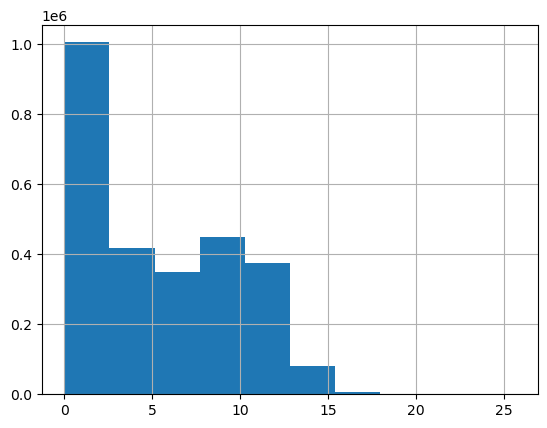

In [35]:
stdf['prd.stream_temp'].hist()

In [36]:
np.nanmedian(cur_df['prd.stream_temp'])

NameError: name 'cur_df' is not defined

In [ ]:
        cur_ens_med = cur_df.groupby('date').median()
        cur_ens_med['doy'] = cur_ens_med.index.dayofyear
        cur_ens_med['season'] = cur_ens_med['doy'].apply(assign_season)

        cur_anomalies = {}
        baseline = cur_ens_med[cur_ens_med.index.year.isin(baseline_period)].groupby('season').median()
        cur_anomalies[f'{baseline_period[0]}s'] = baseline
        
        for per in anomaly_periods:
            cur_anomalies[f'{per[0]}s'] = cur_ens_med[cur_ens_med.index.year.isin(per)].groupby('season').median().subtract(baseline)
        cur_seas_anomalies = pd.concat(cur_anomalies, axis = 1)
        cur_huc_anoms.append(cur_seas_anomalies)
    return pd.concat(cur_huc_anoms, keys = cur_comids)

In [22]:
# Select columns with 'float64' dtype  
float64_cols = list(huc_anoms.select_dtypes(include='float64'))

# The same code again calling the columns
huc_anoms[float64_cols] = huc_anoms[float64_cols].astype('float32')

NameError: name 'huc_anoms' is not defined

## Covariate anomalies

In [246]:
cov_dir_retro = os.path.join(temp_dir, 'preds_retro/')
cov_files_retro = glob.glob(cov_dir_retro + 'seasonal_covariate_anomalies/' + '*.zip')
print(len(cov_files_retro))
print(cov_files_retro[:3])
cov_files_retro.sort()

1542
['/Volumes/Elements/URycki/temp_data/preds_retro/seasonal_covariate_anomalies/1701010107_cov_anoms.zip', '/Volumes/Elements/URycki/temp_data/preds_retro/seasonal_covariate_anomalies/1701010106_cov_anoms.zip', '/Volumes/Elements/URycki/temp_data/preds_retro/seasonal_covariate_anomalies/1701010108_cov_anoms.zip']


In [14]:
%load_ext rpy2.ipython

In [15]:
%%R
install.packages("fst")

R[write to console]: Installing package into ‘/Users/dawn.urycki/Library/R/x86_64/4.3/library’
(as ‘lib’ is unspecified)



--- Please select a CRAN mirror for use in this session ---
Secure CRAN mirrors 

 1: 0-Cloud [https]
 2: Australia (Canberra) [https]
 3: Australia (Melbourne 1) [https]
 4: Australia (Melbourne 2) [https]
 5: Austria (Wien 1) [https]
 6: Belgium (Brussels) [https]
 7: Brazil (PR) [https]
 8: Brazil (SP 1) [https]
 9: Brazil (SP 2) [https]
10: Bulgaria [https]
11: Canada (MB) [https]
12: Canada (ON 1) [https]
13: Canada (ON 2) [https]
14: Chile (Santiago) [https]
15: China (Beijing 2) [https]
16: China (Beijing 3) [https]
17: China (Hefei) [https]
18: China (Hong Kong) [https]
19: China (Jinan) [https]
20: China (Lanzhou) [https]
21: China (Nanjing) [https]
22: China (Shanghai 2) [https]
23: China (Shenzhen) [https]
24: China (Wuhan) [https]
25: Colombia (Cali) [https]
26: Costa Rica [https]
27: Cyprus [https]
28: Czech Republic [https]
29: Denmark [https]
30: East Asia [https]
31: Ecuador (Cuenca) [https]
32: France (Lyon 1) [https]
33: France (Lyon 2) [https]
34: France (Marseille) 

Selection:  70


R[write to console]: trying URL 'https://mirrors.nics.utk.edu/cran/src/contrib/fst_0.9.8.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 274495 bytes (268 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to co

x86_64-apple-darwin13.4.0-clang++ -std=gnu++17 -I"/opt/miniconda3/envs/temp-data-env/lib/R/include" -DNDEBUG  -I'/Users/dawn.urycki/Library/R/x86_64/4.3/library/Rcpp/include' -I'/Users/dawn.urycki/Library/R/x86_64/4.3/library/fstcore/include' -D_FORTIFY_SOURCE=2 -isystem /opt/miniconda3/envs/temp-data-env/include -mmacosx-version-min=10.13 -mmacosx-version-min=10.13 -I/opt/miniconda3/envs/temp-data-env/include    -fPIC  -march=core2 -mtune=haswell -mssse3 -ftree-vectorize -fPIC -fstack-protector-strong -O2 -pipe -stdlib=libc++ -fvisibility-inlines-hidden -fmessage-length=0 -isystem /opt/miniconda3/envs/temp-data-env/include -fdebug-prefix-map=/Users/runner/miniforge3/conda-bld/r-base-split_1728291276454/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/miniconda3/envs/temp-data-env=/usr/local/src/conda-prefix  -c RcppExports.cpp -o RcppExports.o
x86_64-apple-darwin13.4.0-clang++ -std=gnu++17 -I"/opt/miniconda3/envs/temp-data-env/lib/R/include" -DNDEBUG  -I'/Users/dawn.uryc

installing to /Users/dawn.urycki/Library/R/x86_64/4.3/library/00LOCK-fst/00new/fst/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (fst)
R[write to console]: 

R[write to console]: 
R[write to console]: The downloaded source packages are in
	‘/private/var/folders/95/99dy_ns968195cnlvp5xhwqm0000gp/T/Rtmp8GAREQ/downloaded_packages’
R[write to console]: 
R[write to console]: 



In [16]:
%%R
library(fst)
getwd()

R[write to console]: fst package v0.9.8



[1] "/Users/dawn.urycki/Repos/temp-data"


In [17]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [30]:
colsToUse = ['cov.air_temp_ws', 'cov.Flow_log', 'cov.SWE'] # future

In [279]:
colsToUse = ['cov.air_temp_ws', 'cov.NWM_flow_log', 'cov.SWE'] # retro

In [280]:
dataset = 'retro'

In [ ]:
%%time
# Future covariates
fail_list = {}

for i in range(len(hucs)):
    cur_huc = hucs[i]
    print(cur_huc)

    gcm_frames = []
    for cur_gcm in gcms:
        try: gcm_frames.append(ro.r(f"read.fst('/Volumes/Elements/URycki/temp_data/covariates_GCM/{cur_gcm}/huc_{cur_huc}.fst')"))
        except: fail_list['cur_huc'] = cur_gcm  # update this to check if fail_list['cur_huc'] exists; append cur_gcm
        
    if (cur_huc not in fail_list.keys()) & (gcm_frames != []):
        df = pd.concat(gcm_frames)
        df['date'] = pd.to_datetime(df['tim.year'] * 1000 + df['tim.doy'], format='%Y%j')
        print(df.shape)  

        huc_cov_anoms = getSeasonalAnomalies(df, baseline_period = periods['2010s'], 
                            anomaly_periods = [periods[key] for key in ('1990s', '2050s', '2080s')], cols = colsToUse)
        
        #huc_cov_anoms_reindex = huc_cov_anoms.drop(['doy', 'COMID'], level = 1, axis = 1)

        huc_cov_anoms.reset_index(names = ['COMID', 'season']).to_csv(
            os.path.join(temp_dir_gcms, 'seasonal_covariate_anomalies', f'{cur_huc}_cov_anoms.zip'), index = False, compression = 'zip')

In [ ]:
fail_list

In [31]:
indf = df
baseline_period = periods['2010s']
anomaly_periods = [periods[key] for key in ('1990s', '2050s', '2080s')]
cols = colsToUse

In [35]:
huc_cov_anoms

2010s                                                \
                cov.air_temp_ws n_cov.air_temp_ws cov.Flow_log n_cov.Flow_log   
         season                                                                 
22878641 fall          0.100403               930     0.309517            930   
         spring        7.160029               920     2.280978            920   
         summer       15.704421               920     1.171329            920   
         winter       -3.560935               882     0.313072            882   
22878643 fall          0.100403               930     0.309517            930   
...                         ...               ...          ...            ...   
22878661 winter       -3.804153               882    -0.409691            882   
22878663 fall         -0.206795               930    -0.395419            930   
         spring        6.839309               920     1.808414            920   
         summer       15.451771               920     0.425018            920   
         winter       -3.804153               882    -0.409691            882   

                                                  1990s                    \
                      cov.SWE n_cov.SWE cov.air_temp_ws n_cov.air_temp_ws   
         season                                                             
22878641 fall     1382.232207       828       -0.539059               930   
         spring   7806.388924       920       -0.565044               920   
         summer     33.150613      1022       -1.424825               920   
         winter  10728.021235       882       -0.691536               882   
22878643 fall     1382.232207       828       -0.539059               930   
...                       ...       ...             ...               ...   
22878661 winter  14254.584526       882       -0.746843               882   
22878663 fall     1445.515172       828       -0.528471               930   
         spring   7725.610998       920       -0.573852               920   
         summer      0.000000      1022       -1.492018               920   
         winter  14254.584526       882       -0.746843               882   

                                             ...        2050s                 \
                cov.Flow_log n_cov.Flow_log  ... cov.Flow_log n_cov.Flow_log   
         season                              ...                               
22878641 fall       0.170127            930  ...    -0.111811            930   
         spring     0.034979            920  ...    -0.047259            920   
         summer     0.137918            920  ...    -0.325200            920   
         winter     0.062322            882  ...     0.486865            882   
22878643 fall       0.170127            930  ...    -0.111811            930   
...                      ...            ...  ...          ...            ...   
22878661 winter     0.017833            882  ...     0.598496            882   
22878663 fall       0.153512            930  ...    -0.066162            930   
         spring     0.031868            920  ...    -0.068839            920   
         summer     0.150704            920  ...    -0.331209            920   
         winter     0.017833            882  ...     0.598496            882   

                                                 2080s                    \
                     cov.SWE n_cov.SWE cov.air_temp_ws n_cov.air_temp_ws   
         season                                                            
22878641 fall    -294.813268       828        3.679309               930   
         spring -2805.901779       920        3.656638               920   
         summer   -33.150613      1022        5.434981               920   
         winter -1428.859704       882        3.626541               883   
22878643 fall    -294.813268       828        3.679309               930   
...                      ...       ...             ...               ...   
2287866

In [37]:
huc_cov_anoms.reset_index(names = ['COMID', 'season'])

COMID  season           2010s                                 \
                      cov.air_temp_ws n_cov.air_temp_ws cov.Flow_log   
0    22878641    fall        0.100403               930     0.309517   
1    22878641  spring        7.160029               920     2.280978   
2    22878641  summer       15.704421               920     1.171329   
3    22878641  winter       -3.560935               882     0.313072   
4    22878643    fall        0.100403               930     0.309517   
..        ...     ...             ...               ...          ...   
119  22878661  winter       -3.804153               882    -0.409691   
120  22878663    fall       -0.206795               930    -0.395419   
121  22878663  spring        6.839309               920     1.808414   
122  22878663  summer       15.451771               920     0.425018   
123  22878663  winter       -3.804153               882    -0.409691   

                                                     1990s                    \
    n_cov.Flow_log       cov.SWE n_cov.SWE cov.air_temp_ws n_cov.air_temp_ws   
0              930   1382.232207       828       -0.539059               930   
1              920   7806.388924       920       -0.565044               920   
2              920     33.150613      1022       -1.424825               920   
3              882  10728.021235       882       -0.691536               882   
4              930   1382.232207       828       -0.539059               930   
..             ...           ...       ...             ...               ...   
119            882  14254.584526       882       -0.746843               882   
120            930   1445.515172       828       -0.528471               930   
121            920   7725.610998       920       -0.573852               920   
122            920      0.000000      1022       -1.492018               920   
123            882  14254.584526       882       -0.746843               882   

     ...        2050s                                                 2080s  \
     ... cov.Flow_log n_cov.Flow_log      cov.SWE n_cov.SWE cov.air_temp_ws   
0    ...    -0.111811            930  -294.813268       828        3.679309   
1    ...    -0.047259            920 -2805.901779       920        3.656638   
2    ...    -0.325200            920   -33.150613      1022        5.434981   
3    ...     0.486865            882 -1428.859704       882        3.626541   
4    ...    -0.111811            930  -294.813268       828        3.679309   
..   ...          ...            ...          ...       ...             ...   
119  ...     0.598496            882 -2421.909955       882        3.598439   
120  ...    -0.066162            930  -669.936925       828        3.674276   
121  ...    -0.068839            920 -4450.171734       920        3.594385   
122  ...    -0.331209            920     0.000000      1022        5.339664   
123  ...     0.598496            882 -2421.909955       882        3.598439   

                                                                          
    n_cov.air_temp_ws cov.Flow_log n_cov.Flow_log      cov.SWE n_cov.SWE  
0                 930    -0.104206            930  -690.998173       827  
1                 920    -0.115294            920 -5325.020264       920  
2                 920    -0.504115            920   -33.150613      1023  
3                 883     1.179680            883 -4308.032358       883  
4                 930    -0.104206            930  -690.998173       827  
..                ...          ...            ...          ...       ...  
119               883     1.384718            883 -8004.191724       883  
120               930    -0.031307            930  -865.315955       827  
121               920    -0.162504            920 -7227.741609       920  
122               920    -0.470186            920     0.000000      1023  
123               883     1.384718            883 -8004.191724       883  

[124 rows x 26 columns]

In [22]:
gcms

['CanESM2',
 'CCSM4',
 'CNRM-CM5',
 'CSIRO-Mk3-6-0',
 'GDFL-ESM2M',
 'HadGEM-CC365',
 'HadGEM2-ES',
 'inmcm4',
 'IPSL-CM5A-MR',
 'MIROC5']

In [ ]:
cov_files_retro = glob.glob(cov_dir_retro + '/*.fst')
hucs = [f[-14:-4] for f in cov_files_retro]
hucs.sort()
hucs[:5]

In [ ]:
%%time # [~8 hr for full set]
# Retro covariates

for i in range(len(hucs)):
    cur_huc = hucs[i]
    print(cur_huc)

    df = ro.r(f"read.fst('/Volumes/Elements/URycki/temp_data/covariates_retro/huc_{cur_huc}.fst')")

    df['date'] = pd.to_datetime(df['tim.year'] * 1000 + df['tim.doy'], format='%Y%j')
    print(df.shape)  

    huc_cov_anoms = getSeasonalAnomalies(df, baseline_period = periods['2010s'], 
                        anomaly_periods = [periods[key] for key in ('1990s', '2000s')], cols = colsToUse)
    
    huc_cov_anoms.reset_index(names = ['COMID', 'season']).to_csv(
        os.path.join(temp_dir_retro, 'seasonal_covariate_anomalies', f'{cur_huc}_cov_anoms.zip'), index = False, compression = 'zip')


In [347]:
pd.read_csv(os.path.join(temp_dir_retro, 'seasonal_covariate_anomalies', f'{cur_huc}_cov_anoms.zip'), header = [0,1], compression = 'zip')

COMID             season           2010s                    \
   Unnamed: 0_level_1 Unnamed: 1_level_1 cov.air_temp_ws n_cov.air_temp_ws   
0            22878861               fall       -0.928384               930   
1            22878861             spring        4.621116               920   
2            22878861             summer       13.584764               920   
3            22878861             winter       -4.959496               882   
4            22878865               fall        1.111995               930   
5            22878865             spring        7.250537               920   
6            22878865             summer       15.983624               920   
7            22878865             winter       -3.027337               882   
8            22879677               fall        3.946950               930   
9            22879677             spring       10.284000               920   
10           22879677             summer       19.069250               920   
11           22879677             winter       -0.943000               882   
12           22879685               fall        3.946950               930   
13           22879685             spring       10.284000               920   
14           22879685             summer       19.069250               920   
15           22879685             winter       -0.943000               882   

                                                                   1990s  \
   cov.NWM_flow_log n_cov.NWM_flow_log cov.SWE n_cov.SWE cov.air_temp_ws   
0               NaN                  0     0.0         0       -1.448457   
1               NaN                  0     0.0         0       -1.285360   
2               NaN                  0     0.0         0       -1.830384   
3               NaN                  0     0.0         0       -0.568837   
4               NaN                  0     0.0         0       -0.982254   
5               NaN                  0     0.0         0       -1.125068   
6               NaN                  0     0.0         0       -1.473579   
7               NaN                  0     0.0         0       -0.426339   
8               NaN                  0     0.0         0       -1.173950   
9               NaN                  0     0.0         0       -0.571000   
10              NaN                  0     0.0         0       -1.513249   
11              NaN                  0     0.0         0       -0.012500   
12       -11.512925                930     0.0         0       -1.173950   
13        -4.605170                920     0.0         0       -0.571000   
14       -11.512925                920     0.0         0       -1.513249   
15        -4.605170                882     0.0         0       -0.012500   

                                                                            \
   n_cov.air_temp_ws cov.NWM_flow_log n_cov.NWM_flow_log cov.SWE n_cov.SWE   
0                930              NaN                  0     0.0         0   
1                920              NaN                  0     0.0         0   
2                920              NaN                  0     0.0         0   
3                882              NaN                  0     0.0         0   
4                930              NaN                  0     0.0         0   
5                920              NaN                  0     0.0         0   
6                920              NaN                  0     0.0         0   
7                882              NaN                  0     0.0         0   
8                930              NaN                  0     0.0         0   
9                920              NaN                  0     0.0         0   
10               920              NaN                  0     0.0         0   
11               882              NaN                  0     0.0         0   
12               930         0.000000                930     0.0         0   
13               920         0.000000                920     0.0        

In [1]:
pd.read_csv(os.path.join(temp_dir_gcms, 'seasonal_covariate_anomalies', f'{cur_huc}_cov_anoms.zip'), header = [0,1], compression = 'zip')

NameError: name 'pd' is not defined